# GPT-2 for text generation

Part 1

Useful tutorials:  
https://huggingface.co/blog/how-to-generate  
https://github.com/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb

Part2

Tutorial how to use fastai to fine-tune (GPT-2) on my dataset  
https://docs.fast.ai/tutorial.transformers

############  
Run commands to check if GPU available:  

torch.cuda.current_device()   
torch.cuda.device(0)   
torch.cuda.device_count()  
torch.cuda.get_device_name(0)   
torch.cuda.is_available()   
############

In [1]:
import numpy as np

# get transformers
from transformers import GPT2LMHeadModel, GPT2Tokenizer

import torch
print(torch.__version__)

1.7.0


In [4]:
# get GPT2 tokenizer (in charge of preparing the inputs for a model)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')

# 24-layer, 1024-hidden, 16-heads, 345M parameters
# OpenAI’s Medium-sized GPT-2 English model

# add the EOS token as PAD token to avoid warnings
GPT2_model = GPT2LMHeadModel.from_pretrained('gpt2-medium', pad_token_id=tokenizer.eos_token_id, return_dict=True)

In [5]:
# tokenizer example
ids = tokenizer.encode('Let me tell something important about how')

print('encoded representation: ', ids)
print('decoded string: ', tokenizer.decode(ids))

encoded representation:  [5756, 502, 1560, 1223, 1593, 546, 703]
decoded string:  Let me tell something important about how


### Part 1 - Generating some text with plain GPT-2

In [6]:
# prompt for GPT-2
section1_prompt = 'Myocet liposomal contains a medicine called "doxorubicin", which damages tumour cells.' \
                + 'This type of medicine is called "chemotherapy".'

# encode context the generation is conditioned on
section1_prompt_tokenized = tokenizer.encode(section1_prompt)

# make a suitable input to generate() method that expects a batch of prompt
# make pytorch LongTensor and add one batch dimension
section1_begining = torch.LongTensor(section1_prompt_tokenized)[None]

#### Greedy decoding

[Documentation Link](https://huggingface.co/transformers/main_classes/model.html#transformers.generation_utils.GenerationMixin.generate)

In [7]:
# generate text until the output length (which includes the context length) reaches 300
greedy_output = GPT2_model.generate(section1_begining, max_length=300)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
Myocet liposomal contains a medicine called "doxorubicin", which damages tumour cells.This type of medicine is called "chemotherapy". It is used to treat cancer, and is used to treat many other diseases. It is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of cancer.

The drug is also used to treat some types of 

**Summary**:
The generated words following the context are reasonable, but the model quickly starts repeating itself! Turns out it to be a common problem (Is it like in GANs - mode collapse) in language generation the same problem - "seems to be even more so in greedy and beam search"

Greedy - on each step, take the most probable word (argmax)
- simple method that gives low quiality output

#### Beam search decoding

Beam search keeps the most likely *num_beams* of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability.

[Documentation Link](https://huggingface.co/transformers/main_classes/model.html#transformers.generation_utils.GenerationMixin.generate)

In [8]:
# beam search decoding
# num_beams=5
beam_output = GPT2_model.generate(
    section1_begining,
    max_length=500,
    num_beams=5,
    no_repeat_ngram_size=2,
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
Myocet liposomal contains a medicine called "doxorubicin", which damages tumour cells.This type of medicine is called "chemotherapy". It is used to treat cancerous tumours. It has been shown to be very effective in treating some types of cancer. However, it has not been proven that it is safe for use in the treatment of other cancers.


In [9]:
# multiple generated samples
beam_output = GPT2_model.generate(
    section1_begining,
    max_length=500,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True
)

print("Output:\n" + 100 * '-')
for i, beam_output_sample in enumerate(beam_output):
  print("{}: {}".format(i, tokenizer.decode(beam_output_sample, skip_special_tokens=True)))

Output:
----------------------------------------------------------------------------------------------------
0: Myocet liposomal contains a medicine called "doxorubicin", which damages tumour cells.This type of medicine is called "chemotherapy". It is used to treat cancerous tumours. It has been shown to be very effective in treating some types of cancer. However, it has not been proven that it is safe for use in the treatment of other cancers.
1: Myocet liposomal contains a medicine called "doxorubicin", which damages tumour cells.This type of medicine is called "chemotherapy". It is used to treat cancerous tumours. It has been shown to be very effective in treating some types of cancer. However, it has not been proven that it is safe for use in the treatment of other cancers.

What are the possible side effects of myofascial release therapy?


There are a number of possible adverse effects that may occur with the use of this therapy. These include, but are not limited to,:
2: Myocet 

**Summary**: Detter quality text but *cons*: playing with parameters, generated text - boring, still repetetive in some ways

#### Sampling based Decoding
= sampling means randomly picking the next word according to its conditional probability distribution:

Result: more randomness (like humans), thus more diversity but text might be not coherent (too random)

[Documentation Link](https://huggingface.co/transformers/main_classes/model.html#transformers.generation_utils.GenerationMixin.generate)

(actually it is Top-K Sampling)
\- In Top-K sampling, the K most likely next words are filtered and the probability mass is redistributed among only those K next words. GPT2 adopted this sampling scheme, which was one of the reasons for its success in story generation.

In [10]:
# set seed to reproduce results. Feel free to change the seed though to get different results
torch.manual_seed(7)

# use temperature to decrease the sensitivity to low probability candidates
sample_output = GPT2_model.generate(
    section1_begining,
    do_sample=True,
    max_length=500,
    top_k=50,
    temperature=0.7
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
Myocet liposomal contains a medicine called "doxorubicin", which damages tumour cells.This type of medicine is called "chemotherapy". It is used to treat people who have had cancer or other cancers for two to three months. It is also used to treat people with diabetes.Chemotherapy is also used to treat certain other conditions. It prevents the growth of existing tumours. It is also used to treat people with heart, lung and kidney problems.When the doctor gives a treatment to a patient with cancer or other conditions, the medicine used in the treatment is called "chemotherapy".Chemotherapy is used to treat cancer or other types of diseases. It is an advanced form of medicine. It involves destroying cancerous cells within the body. It is also used to treat some types of infections.Chemotherapy does not affect the normal functioning of the body. It causes long-term damage to the bo

**Summary**:  
**Temperature** parameter to make distribution "sharper" - to increase fluency(naturalness) of a text by decreasing the sensitivity to low probability candidates

**Top-K** limit our sampling pool to k words - more naturalness, but limit the model's creativity for flat distribution

#### Top-p (nucleus) sampling

Instead of sampling only from the most likely K words, in Top-p sampling chooses from the smallest possible set of words whose cumulative probability exceeds the probability p. The probability mass is then redistributed among this set of words. This way, the size of the set of words (a.k.a the number of words in the set) can dynamically increase and decrease according to the next word's probability distribution.

[Documentation Link](https://huggingface.co/transformers/main_classes/model.html#transformers.generation_utils.GenerationMixin.generate)

In [11]:
# set seed to reproduce results. Feel free to change the seed though to get different results
torch.manual_seed(7)

# deactivate top_k sampling and sample only from 92% most likely words
sample_output = GPT2_model.generate(
    section1_begining, 
    do_sample=True, 
    max_length=500, 
    top_p=0.92, 
    top_k=0
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
Myocet liposomal contains a medicine called "doxorubicin", which damages tumour cells.This type of medicine is called "chemotherapy".Doxorubicin causes tumours to open and release toxins that cause swelling and inflammation, killing the cancer. So you have to be careful that your product can actually kill the cancer, even if it prevents it from growing. This isn't the only way in which this product can cause headaches and headaches, so we recommend carefully examining any product you consider use.Overall you have a lot of options with China Liposomal. Some are cheaper, but you will see different options offered in each given region. Some are listed above as a Doctor's Supplier, which is also offered through QQ Marketplace, but then only ships within China, and certain channels can be expensive, leaving you with only low-margin companies such as China Lifescience and Markl Tech, 

While in theory, Top-p seems more elegant than Top-K, both methods work well in practice. Top-p can also be used in combination with Top-K, which can avoid very low ranked words while allowing for some dynamic selection.

In [12]:
# set seed to reproduce results. Feel free to change the seed though to get different results
torch.manual_seed(7)

# set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
sample_outputs = GPT2_model.generate(
    section1_begining,
    do_sample=True, 
    max_length=500, 
    top_k=50, 
    top_p=0.95, 
    num_return_sequences=3
)

print("Output:\n" + 100 * '-')
for i, sample_output in enumerate(sample_outputs):
    print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
    print("\n")

Output:
----------------------------------------------------------------------------------------------------
0: Myocet liposomal contains a medicine called "doxorubicin", which damages tumour cells.This type of medicine is called "chemotherapy".Doxorubicin is also sometimes referred to as "Craniosurgery", this is a form of chemotherapy that is used on people with cancer and is also used on people that have the skin cancer that they have.The effect of chemo is:A tumour is removed and the patient gets the treatment "Craniosurgery". The cure is called "remission" where the tumour is cured and a new patient is brought into treatment,but chemo and chemotherapy is very painful for some people.Doxorubicin is the most effective and most common treatment used on those with breast cancer and those who have had skin cancer, and is widely used to treat cancers of the mouth,throat and liver.This chemo was called 'chronic pain'and that is what the chemotherapy drugs do to your body.The reason the do

### Task-2 Fine-tune GPT-2 on the dataset

In [2]:
from fastai.text.all import *

import pickle

In [3]:
# description of an objects in dataset
class Leaflet():
    def __init__(self, product_name, product_url, product_id, product_content):
        self.product_name = product_name
        self.url = product_url
        self.id = product_id
        self.content = product_content

        # extract sections later
        self.section1 = None

    def print_info(self):
        print(self.product_name)
        print(self.url)
        print(self.id)

    def print_section1(self):
        print(self.section1)

In [4]:
# load array of objects, where object - class Leaflet
with open("datasets/LeafletsDataset_section1_v0.dat", "rb") as f:
    loaded_package_leaflets = pickle.load(f)

In [5]:
len(loaded_package_leaflets)

1351

In [6]:
loaded_package_leaflets[0].section1

' 1. What Trydonis is and what it is used for Trydonis is a medicine to help breathing that contains the three active substances: • beclometasone dipropionate, • formoterol fumarate dihydrate and • glycopyrronium. Beclometasone dipropionate belongs to a group of medicines called corticosteroids which act to reduce the swelling and irritation in your lungs. Formoterol and glycopyrronium are medicines called long-acting bronchodilators. They act in different ways to relax the muscles in your airways, helping to open the airways wider and allowing you to breathe more easily. Regular treatment with these three active substances helps to relieve and prevent symptoms such as shortness of breath, wheezing and cough in adult patients with chronic obstructive pulmonary disease (COPD). Trydonis can reduce exacerbations (flare-ups) of COPD symptoms. COPD is a serious long- term disease in which the airways become blocked and air sacs inside the lungs become damaged, leading to difficulty breathin

#### Preparing the data

In [7]:
# gather all texts in one numpy array (since it will be easier to use this way with fastai)

tmp = []

# TODO 600 just to reduce computations
for leaflet in loaded_package_leaflets[:600]:
    # skik if section1 content is empty
    if leaflet.section1 is not None:
        tmp.append(leaflet.section1)

# array to store all first sections
all_section1 = np.array(tmp)

# set the threshold to split all data to train (all indexes before) and validation (all indexes after)
threshold_train_val = 500

In [8]:
all_section1.shape

(553,)

"To process this data to train a model, we need to build a Transform that will be applied lazily. In this case we could do the pre-processing once and for all and only use the transform for decoding"

In [9]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): 
        self.tokenizer = tokenizer
        
    def encodes(self, x):
        """
        encodes method that is applied when you call the transform (a bit like the forward method in a nn.Module)
        """
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    
    def decodes(self, x):
        """
        decodes method that is applied when you call the decode method of the transform, 
        (if you need to decode anything for showing purpose)
        
        in decodes we return a TitledStr object and not just a plain string. 
        That's a fastai class that adds a show method to the string, which will allow us to use all the fastai show methods
        """
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [10]:
# indicate the indices of the training set and the validation set with splits 
# (here all the first indices until <threshold_train_val> and then all the remaining indices):
splits = [range_of(threshold_train_val), list(range(threshold_train_val, len(all_section1)))]

In [13]:
# group data with this Transform using a TfmdLists
tls = TfmdLists(all_section1, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [14]:
# in a TfmdLists you can access the elements of the training or validation set quite easily
tls.train[0], tls.valid[0]

(tensor([  352,    13,  1867,  9993,  9099,   271,   318,   290,   644,   340,
           318,   973,   329,  9993,  9099,   271,   318,   257,  9007,   284,
          1037, 12704,   326,  4909,   262,  1115,  4075, 15938,    25,  5595,
           307,   565,   908,   292,   505, 19550,  1773,   295,   378,    11,
          5595,  1296, 19543,   349,   277,   388, 30748,  2566, 15511,  4873,
           290,  5595, 13874, 22163,  2417,  1313,  1505,    13,  1355,   565,
           908,   292,   505, 19550,  1773,   295,   378, 14448,   284,   257,
          1448,   286, 23533,  1444, 12794,   291,  6197, 10994,   543,   719,
           284,  4646,   262, 29844,   290, 35164,   287,   534, 21726,    13,
          5178, 19543,   349,   290, 13874, 22163,  2417,  1313,  1505,   389,
         23533,  1444,   890,    12, 27362, 18443,   354,   375,   346,  2024,
            13,  1119,   719,   287,  1180,  2842,   284,  8960,   262, 12749,
           287,   534,  1633,  1322,    11,  5742,  

In [15]:
tls.tfms(tls.train.items[0]).shape, tls.tfms(tls.valid.items[0]).shape

(torch.Size([228]), torch.Size([116]))

In [16]:
show_at(tls.train, 0)

 1. What Trydonis is and what it is used for Trydonis is a medicine to help breathing that contains the three active substances: • beclometasone dipropionate, • formoterol fumarate dihydrate and • glycopyrronium. Beclometasone dipropionate belongs to a group of medicines called corticosteroids which act to reduce the swelling and irritation in your lungs. Formoterol and glycopyrronium are medicines called long-acting bronchodilators. They act in different ways to relax the muscles in your airways, helping to open the airways wider and allowing you to breathe more easily. Regular treatment with these three active substances helps to relieve and prevent symptoms such as shortness of breath, wheezing and cough in adult patients with chronic obstructive pulmonary disease (COPD). Trydonis can reduce exacerbations (flare-ups) of COPD symptoms. COPD is a serious long- term disease in which the airways become blocked and air sacs inside the lungs become damaged, leading to difficulty breathing

In [17]:
show_at(tls.valid, 0)

 1. What Rhokiinsa is and what it is used for Rhokiinsa contains an active substance called netarsudil. Netarsudil belongs to a group of medicines called “Rho kinase inhibitors”, which work to reduce the amount of fluid inside the eye and so lower its pressure. Rhokiinsa is used to lower pressure in the eyes in adults who have an eye condition known as glaucoma or who have raised pressure in their eyes. If the pressure in the eye is too high, it can damage your sight.


In [18]:
# specify a batch size and a sequence length. (GPT2 model was trained with sequences of size 1024)
batch_size = 1
sequence_length = 1024

# fastai expects the data to be assembled in a DataLoaders object (something that has a training and validation dataloader) 
# We can get one by using the dataloaders method
dls = tls.dataloaders(bs=batch_size, seq_len=sequence_length)

In [19]:
# have a look at the data (here texts for inputs, and the same text shifted by one token to the right for validation)
dls.show_batch(max_n=2)

,text,text_
0,"1. What Darunavir Krka d.d. is and what it is used for What is Darunavir Krka d.d.? Darunavir Krka d.d. contains the active substance darunavir. Darunavir Krka d.d. is an antiretroviral medicine used in the treatment of Human Immunodeficiency Virus (HIV) infection. It belongs to a group of medicines called protease inhibitors. Darunavir Krka d.d. works by reducing the amount of HIV in your body. This will improve your immune system and reduces the risk of developing illnesses linked to HIV infection. What it is used for? The Darunavir Krka d.d. 400 and 800 milligram tablets are used to treat adults and children (3 years of age and above, at least 40 kilograms body weight) who are infected by HIV and  who have not used antiretroviral medicines before.  in certain patients who have used antiretroviral medicines before (your doctor will determine this). Darunavir Krka d.d. must be",". What Darunavir Krka d.d. is and what it is used for What is Darunavir Krka d.d.? Darunavir Krka d.d. contains the active substance darunavir. Darunavir Krka d.d. is an antiretroviral medicine used in the treatment of Human Immunodeficiency Virus (HIV) infection. It belongs to a group of medicines called protease inhibitors. Darunavir Krka d.d. works by reducing the amount of HIV in your body. This will improve your immune system and reduces the risk of developing illnesses linked to HIV infection. What it is used for? The Darunavir Krka d.d. 400 and 800 milligram tablets are used to treat adults and children (3 years of age and above, at least 40 kilograms body weight) who are infected by HIV and  who have not used antiretroviral medicines before.  in certain patients who have used antiretroviral medicines before (your doctor will determine this). Darunavir Krka d.d. must be taken"


#### Fine-tuning the model

In [20]:
"""
The HuggingFace model will return a tuple in outputs, with the actual predictions and some additional activations. 
To work inside the fastai training loop, we will need to drop those using a Callback
"""

class DropOutput(Callback):
    def after_pred(self): 
        """
        write the event after_pred and replace self.learn.pred (which contains the predss that will be passed to the loss function) 
        by just its first element.
        """
        self.learn.pred = self.pred[0]

In [12]:
### TODO - use a smaller GPT model

pretrained_weights = 'gpt2'
# tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_weights)
### TODO

In [20]:
"""
Learner - fastai object grouping data, model and loss function and handles model training or inference. 
Pass perplexity as a metric (bc language model setting), and we need to use the callback we just defined. 
"""

learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [21]:
# check how good the model is without any fine-tuning step
# lists the validation loss and metrics (e.g. 26.6 as perplexity is kind of amazing)
learn.validate()

(#2) [2.3597071170806885,10.587849617004395]

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=1.0964781722577754e-06)

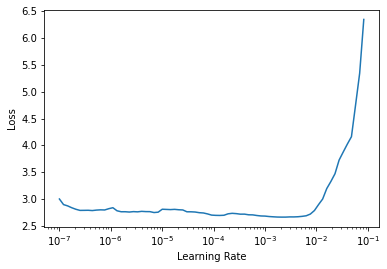

In [22]:
# Learning rate finder plots lr vs loss relationship for a Learner. (The idea is to reduce the amount of guesswork on picking a good starting learning rate)
# Pick a learning rate before it diverges then start training
learn.lr_find()

In [24]:
# just one epoch of fine-tuning and not much regularization, our model did not really improve since it was already amazing

learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,perplexity,time
0,2.454669,1.816596,6.150886,01:12


In [45]:
learn.validate()

(#2) [1.8165961503982544,6.150886058807373]

#### Test generation given how the section begins

In [43]:
# create prompt that looks like the begining of a section1 to generate text:
prompt = ' 1. What Trydonis is and what it is used for '

# prompt needs to be tokenized and numericalized
prompt_ids = tokenizer.encode(prompt)

# input - LongTensor
prompt_ids = torch.LongTensor(prompt_ids)[None].cuda()

prompt_ids.shape

torch.Size([1, 14])

In [44]:
beam_output_test = learn.model.generate(
                    prompt_ids,
                    max_length=300,
                    num_beams=5,
                    no_repeat_ngram_size=4,
                    early_stopping=True,
                    temperature=0.5
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output_test[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
 1. What Trydonis is and what it is used for erythropoietin belongs to a group of medicines called antipsychotics. It is used to treat schizophrenia in adults and adolescents aged 12 years and older. It works by reducing the amount of antipsychotic medication you have taken and by increasing your ability to communicate with each other. This medicine works by helping to control the level of dopamine in your brain and by helping to prevent your symptoms from coming back. If you have any questions about how Trydonis works or why this medicine has been prescribed for you, ask your doctor or pharmacist. 1. What Nivestig is and how it works NivestIG contains the active substance nivestig which belongs to a class of medicines called dopamine agonists (DPA), which are used to treat Parkinson’s disease (PDD) in adults, adolescents and children aged 2 years and above. This medicine acts o

In [34]:
# find reference section1, drug = 'Trydonis'
for leaflet in loaded_package_leaflets[:600]:
    if leaflet.product_name == 'Trydonis':
        leaflet.print_section1()

 1. What Trydonis is and what it is used for Trydonis is a medicine to help breathing that contains the three active substances: • beclometasone dipropionate, • formoterol fumarate dihydrate and • glycopyrronium. Beclometasone dipropionate belongs to a group of medicines called corticosteroids which act to reduce the swelling and irritation in your lungs. Formoterol and glycopyrronium are medicines called long-acting bronchodilators. They act in different ways to relax the muscles in your airways, helping to open the airways wider and allowing you to breathe more easily. Regular treatment with these three active substances helps to relieve and prevent symptoms such as shortness of breath, wheezing and cough in adult patients with chronic obstructive pulmonary disease (COPD). Trydonis can reduce exacerbations (flare-ups) of COPD symptoms. COPD is a serious long- term disease in which the airways become blocked and air sacs inside the lungs become damaged, leading to difficulty breathing

#### Try again fine-tuning for 1 epoch

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

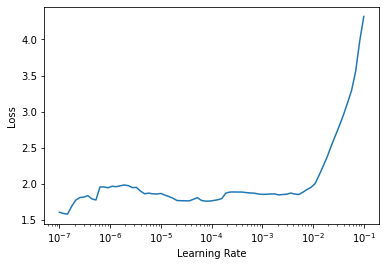

In [46]:
learn.lr_find()

In [47]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,perplexity,time
0,2.067131,1.943096,6.980330,01:11


In [48]:
learn.validate()

(#2) [1.9430961608886719,6.980329990386963]

perplexity - UP ?

In [55]:
beam_output_test_2 = learn.model.generate(
                    prompt_ids,
                    max_length=300,
                    num_beams=5,
                    no_repeat_ngram_size=3,
                    early_stopping=True,
                    temperature=0.5
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output_test_2[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
 1. What Trydonis is and what it is used for ertin belongs to a group of medicines called ‘oral anticoagulants� which are used for the treatment of adult patients with type 2 diabetes mellitus (a type of diabetes that affects the blood vessels in the heart) in adults, adolescents and children aged 2 years and older who are unable to take a medicine called insulin because they are not able to make enough insulin to control blood sugar (glucose) levels in the blood which can lead to a heart attack, heart failure, heart disease, kidney disease, blindness, blindness or blindness in the eye, heart or kidney that is damaged or damaged in some parts of the body which may lead to heart disease or kidney disease in people who are at high risk for heart disease and kidney disease who have not been previously treated with other medicines, such as metformin or sulphonylurea (another medicin

#### Try again fine-tuning for 1 more epoch

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=1.5848931980144698e-06)

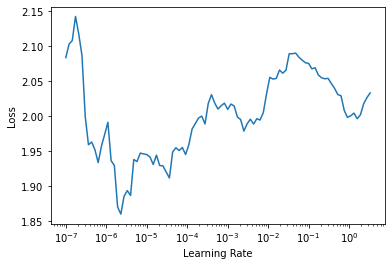

In [56]:
learn.lr_find()

In [57]:
learn.fit_one_cycle(1, 2.2)

epoch,train_loss,valid_loss,perplexity,time
0,8.440320,9.077868,8759.267578,01:11


In [58]:
learn.validate()

(#2) [9.07786750793457,8759.267578125]

perplexity - BOOM!

In [59]:
beam_output_test_3 = learn.model.generate(
                    prompt_ids,
                    max_length=300,
                    num_beams=5,
                    no_repeat_ngram_size=3,
                    early_stopping=True,
                    temperature=0.5
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output_test_2[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
 1. What Trydonis is and what it is used for ertin belongs to a group of medicines called ‘oral anticoagulants� which are used for the treatment of adult patients with type 2 diabetes mellitus (a type of diabetes that affects the blood vessels in the heart) in adults, adolescents and children aged 2 years and older who are unable to take a medicine called insulin because they are not able to make enough insulin to control blood sugar (glucose) levels in the blood which can lead to a heart attack, heart failure, heart disease, kidney disease, blindness, blindness or blindness in the eye, heart or kidney that is damaged or damaged in some parts of the body which may lead to heart disease or kidney disease in people who are at high risk for heart disease and kidney disease who have not been previously treated with other medicines, such as metformin or sulphonylurea (another medicin

In [3]:
gpu = 0
torch.cuda.set_device(gpu)
print(f'cuda device: {torch.cuda.current_device()}')
# print(f'cuda device name: {torch.cuda.get_device_name(gpu)}')

cuda device: 0


In [4]:
torch.cuda.current_device()

0

In [5]:
torch.cuda.device(0)

In [6]:
torch.cuda.device_count()

1

In [7]:
torch.cuda.get_device_name(0)

'Tesla M60'

In [8]:
torch.cuda.is_available()

True

torch.cuda.current_device()

torch.cuda.device(0)

torch.cuda.device_count()

torch.cuda.get_device_name(0)

torch.cuda.is_available()


We can check how good the model is without any fine-tuning step.

In [ ]:
%%time
# loss, accuracy, Perplexity() of validation dataset
learn.validate()

CPU times: user 4h 45min 53s, sys: 1h 1min 36s, total: 5h 47min 30s
Wall time: 53min 2s


(#3) [9.949938774108887,0.09898579120635986,20950.939453125]

- Loss = 9.95
- accuracy = 0.099
- perplexity = 20950.94

Now that we have a `Learner`, we will use during training all the **fine-tuning techniques** seen for classification model training (see the notebook [10_nlp.ipynb](https://github.com/fastai/fastbook/blob/master/10_nlp.ipynb) about "NLP Deep Dive: RNNs") to take advantage of the **Transfer Learning** of the GPT-2 pre-trained embeddings and model from Hugging Face Transformers:
- **learning rate finder** (method that helps finding the best learning rate to train the model)
- **Mixed precision training** (some of the operations will be done in FP16, others in FP32 in order to speed up the training)
- **gradual unfreezing** (the model has 4 layers groups created by our method `splitter` : the embedding one and the 3 groups of 4 decoder blocks each)
- **1cycle policy** with the method [fit_one_cycle()](https://dev.fast.ai/callback.schedule#Learner.fit_one_cycle) (The 1cycle policy was introduced by Leslie N. Smith et al. in <a href="https://arxiv.org/abs/1708.07120">Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates</a>. It schedules the learning rate with a cosine annealing from `lr_max/div` to `lr_max` then `lr_max/div_final` (pass an array to `lr_max` if you want to use differential learning rates) and the momentum with cosine annealing according to the values in `moms`. The first phase takes `pct_start` of the training. You can optionally pass additional `cbs` and `reset_opt`.)
- **differential learning rates** (each layers group with a learning rate different: the biggest one for the embeddings group, and the smallest one for the first 4 decoder blocks)

##### 6.2.1 Freeze all layers but the last layers group (do not freeze `wte`, `wpe` embeddings matrices and last `LayerNorm`)

CPU times: user 4min 21s, sys: 58.9 s, total: 5min 20s
Wall time: 1min 5s


SuggestedLRs(lr_min=0.005754399299621582, lr_steep=2.2908675418875646e-06)

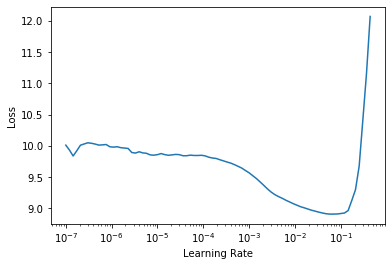

In [ ]:
%%time
learn.freeze()
learn.lr_find()

The learning rate finder curve suggests picking a lr min of 6e-3. Let's use 2e-3.

In [ ]:
learn.fit_one_cycle(1, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.803344,3.640777,0.325177,38.121441,5:48:31


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



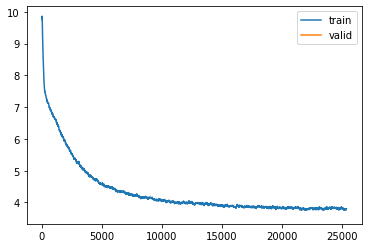

In [ ]:
#hide
learn.recorder.plot_loss()

In just **one epoch**, our model passed 
- from an accuracy of 9.90% to **32.52%**
- from a perplexity of 20950.94 to **38.12**

Not too bad! 

Now, We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups.

In [ ]:
learn.save(path_data/'GPT2_pt_1epoch_lr2e-3')
learn = learn.load(path_data/'GPT2_pt_1epoch_lr2e-3')

##### 6.2.2 Freeze all layers but the last 2 layers groups

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.453913,3.301886,0.362879,27.163816,5:38:18


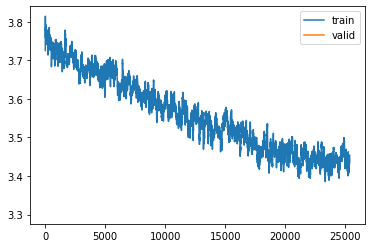

In [ ]:
#hide
learn.recorder.plot_loss()

In [ ]:
learn.save(path_data/'GPT2_pt_2epoch_lr1e-3')
learn = learn.load(path_data/'GPT2_pt_2epoch_lr1e-3')

##### 6.2.3 Freeze all layers but the last 3 layers groups

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-4/(2.6**4),5e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.333389,3.207390,0.374579,24.714487,6:20:51


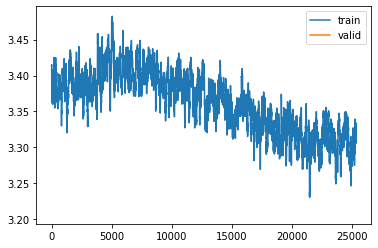

In [ ]:
#hide
learn.recorder.plot_loss()

In [ ]:
learn.save(path_data/'GPT2_pt_3epoch_lr5e-4')
learn = learn.load(path_data/'GPT2_pt_3epoch_lr5e-4')

##### 6.2.4 Unfreeze all layers

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-4/(2.6**4),1e-4))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.288433,3.186721,0.377380,24.208906,6:06:29
1,3.232569,3.167864,0.379885,23.756687,6:16:22


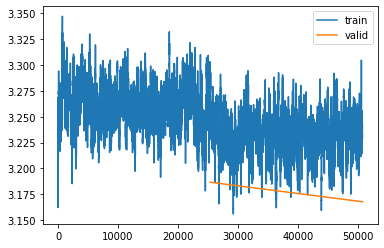

In [ ]:
#hide
learn.recorder.plot_loss()

In [ ]:
learn.save(path_data/'GPT2_pt_5epoch_lr1e-4_v2')
learn = learn.load(path_data/'GPT2_pt_5epoch_lr1e-4_v2')

## Text Generation by our Portuguese GPT-2

Now that we have a GPT-2 in Portuguese, we can use it for different tasks in NLP (Text Generation, Reading Comprehension, Translation, Summary) as showed in the post "**GPT-2 use cases: beyond Text Generation**".

For now, let's use it to generate new texts, which allows us to check that it works properly and also have a little fun.

### Text Generation techniques 

**At each stage of text generation, GPT-2 provides a vector of 50.257 probabilities** (each corresponds to a possible token of the vocabulary whose size is 50.257). To decide how to choose the output token from these probabilities, **there are at least 5 methods: Greedy, Beam Search, Sampling with temperature, Top-k sampling and Top-p (nucleus) sampling**.

In this tutorial, we will test only 2 of these text generation methods: **Top-k sampling** and **Top-p (nucleus) sampling**.

Note: to get more information on text generation techniques for transformer-based language model, read the article "[How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate)" from [Patrick von Platen](https://huggingface.co/patrickvonplaten) (Hugging Face, 03/18/2020).

#### (Use case 1) Top-k sampling

Our use case 1 follows the same method used by OpenAI in page 20 of the paper [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) by choosing **Top-k sampling** text generation technique with a **value of 40**.

This text generation method is implemented in the `model.generate()` function of a Transformers model thanks to the following arguments:
- `top_k` (int): the number of highest probability vocabulary tokens to keep for top-k-filtering. Between 1 and infinity. Default to 50.

#### (Use case 2) Top-p (nucleus) sampling

Our use case 2 follows the [top-p (nucleus) sampling](https://huggingface.co/blog/how-to-generate#top-p-nucleus-sampling) method with Top-p sampling (top_p = 0.95), top-k sampling (top_k = 50), temperature (temperature = 0.7) and repetition penalty (repetition_penalty = 1.2).

This text generation method is implemented in the `model.generate()` function of a Transformers model thanks to the following arguments:
- `top_p` (float): the cumulative probability of parameter highest probability vocabulary tokens to keep for nucleus sampling. Must be between 0 and 1. Default to 1.
- `top_k` (int): the number of highest probability vocabulary tokens to keep for top-k-filtering. Between 1 and infinity. Default to 50.
- `temperature` (float): the value used to module the next token probabilities. Must be strictly positive. Default to 1.0.
- `repetition_penalty` (float): the parameter for repetition penalty. Between 1.0 and infinity. 1.0 means no penalty. Default to 1.0.

### Text n°1 | Famous OpenAI generated text about unicorns

At the time of publication of GPT-2 in the article "[Better Language Models and Their Implications](https://openai.com/blog/better-language-models/)" (02/14/2019), the media retained from its different possibilities in NLP that of text generation because of the now famous text generated on unicorns from this small paragraph:

>In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

From this text, GPT-2 wrote the following [sample](https://openai.com/blog/better-language-models/#samples) out of 10 tries:

In [ ]:
openai_generated_text_en = "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. \
\n\nThe scientist named the population, after their distinctive horn, Ovid's Unicorn. These four-horned, silver-white unicorns were previously unknown to science. \
\n\nNow, after almost two centuries, the mystery of what sparked this odd phenomenon is finally solved. \
\n\nDr. Jorge Pérez, an evolutionary biologist from the University of La Paz, and several companions, were exploring the Andes Mountains when they found a small valley, with no other animals or humans. Pérez noticed that the valley had what appeared to be a natural fountain, surrounded by two peaks of rock and silver snow. \
\n\nPérez and the others then ventured further into the valley. “By the time we reached the top of one peak, the water looked blue, with some crystals on top,” said Pérez. \
\n\nPérez and his friends were astonished to see the unicorn herd. These creatures could be seen from the air without having to move too much to see them – they were so close they could touch their horns. \
\n\nWhile examining these bizarre creatures the scientists discovered that the creatures also spoke some fairly regular English. Pérez stated, “We can see, for example, that they have a common ‘language,’ something like a dialect or dialectic.” \
\n\nDr. Pérez believes that the unicorns may have originated in Argentina, where the animals were believed to be descendants of a lost race of people who lived there before the arrival of humans in those parts of South America. \
\n\nWhile their origins are still unclear, some believe that perhaps the creatures were created when a human and a unicorn met each other in a time before human civilization. According to Pérez, “In South America, such incidents seem to be quite common.” \
\n\nHowever, Pérez also pointed out that it is likely that the only way of knowing for sure if unicorns are indeed the descendants of a lost alien race is through DNA. “But they seem to be able to communicate in English quite well, which I believe is a sign of evolution, or at least a change in social organization,” said the scientist."

print(openai_generated_text_en)

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. 

The scientist named the population, after their distinctive horn, Ovid's Unicorn. These four-horned, silver-white unicorns were previously unknown to science. 

Now, after almost two centuries, the mystery of what sparked this odd phenomenon is finally solved. 

Dr. Jorge Pérez, an evolutionary biologist from the University of La Paz, and several companions, were exploring the Andes Mountains when they found a small valley, with no other animals or humans. Pérez noticed that the valley had what appeared to be a natural fountain, surrounded by two peaks of rock and silver snow. 

Pérez and the others then ventured further into the valley. “By the time we reached the top of one peak, the water looked blue, with some crystals on top,” said Pérez. 

Pérez and h

#### Reload Portuguese GPT-2

##### English pre-trained GPT-2

In [ ]:
%%time
from transformers import GPT2TokenizerFast, GPT2LMHeadModel

pretrained_weights = 'gpt2'
tokenizer_en = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model_en = GPT2LMHeadModel.from_pretrained(pretrained_weights)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CPU times: user 14.4 s, sys: 1.8 s, total: 16.2 s
Wall time: 7.72 s


##### Portuguese tokenizer

In [ ]:
from transformers import GPT2TokenizerFast

# Get the path to ByteLevelBPE_tokenizer_pt config files
ByteLevelBPE_tokenizer_pt_rep = 'ByteLevelBPE_tokenizer_pt'
path_to_ByteLevelBPE_tokenizer_pt_rep = path_data/ByteLevelBPE_tokenizer_pt_rep

# import the pre-trained GPT2TokenizerFast tokenizer with the tokenizer_pt config files
tokenizer_pt = GPT2TokenizerFast.from_pretrained(
    str(path_to_ByteLevelBPE_tokenizer_pt_rep), 
    pad_token='<|endoftext|>')

# Get sequence length max of 1024
tokenizer_pt.model_max_length = 1024

##### Datasets

In [ ]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [ ]:
# get data
lang = 'pt'
fname = f'all_texts_{lang}wiki.csv'
df = pd.read_csv(path_data/fname)

# load idxs train and valid
idxs_train = torch.load(path_data/'idxs_train.pt')
idxs_val = torch.load(path_data/'idxs_val.pt')

all_texts = np.concatenate([df.iloc[idxs_train].text.values, df.iloc[idxs_val].text.values])
splits = [list(idxs_train), list(idxs_val)]
tls = TfmdLists(all_texts, TransformersTokenizer(tokenizer_pt), splits=splits, dl_type=LMDataLoader)

##### Dataloaders

In [ ]:
%%time
bs,sl = 8,1024
dls = tls.dataloaders(bs=bs, seq_len=sl)

CPU times: user 27min 56s, sys: 3min 20s, total: 31min 16s
Wall time: 25min 8s


##### Split a GPT2 model in 4 groups for differential learning rates

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [ ]:
def splitter(model):
    "Split a GPT2 `model` in 3 groups for differential learning rates."
    
    # First layers group : decoder blocks from 0 to 3
    modules = []
    for i in range(4): modules.append(model.transformer.h[i])
    groups = [nn.Sequential(*modules)]

    # Second layers group : decoder blocks from 4 to 7
    modules = []
    for i in range(4,8,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])

    # Third layers group : decoder blocks from 8 to 11
    modules = []
    for i in range(8,12,1): modules.append(model.transformer.h[i])
    groups = L(groups + [nn.Sequential(*modules)])
    
    # Fourth layers group : embeddings matrices wte and wpe + LayerNorm at the model output
    groups = L(groups + [nn.Sequential(model.transformer.wte,model.transformer.wpe,model.transformer.ln_f)])
    
    return groups.map(params)

##### Learner

In [ ]:
# Learner: basic class for handling the training loop
# source: https://dev.fast.ai/learner#Learner
learn = Learner(dls, model_en, loss_func=CrossEntropyLossFlat(),
                splitter = splitter,
                cbs=[DropOutput], 
                metrics=[accuracy, Perplexity()]).to_fp16()
learn = learn.load(path_data/'GPT2_pt_5epoch_lr1e-4_v2')

In [ ]:
# model
model_pt = learn.model

In [ ]:
# put model into eval mode and on GPU
model_pt.eval();
model_pt.to('cuda');

#### Get translated famous unicorn text in Portuguese

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

In [ ]:
# MarianMT Translator
model_name = 'Helsinki-NLP/opus-mt-en-ROMANCE'
tokenizer_en_pt = MarianTokenizer.from_pretrained(model_name)
print(tokenizer_en_pt.supported_language_codes)
model_en_pt = MarianMTModel.from_pretrained(model_name)

['>>fr<<', '>>es<<', '>>it<<', '>>pt<<', '>>pt_br<<', '>>ro<<', '>>ca<<', '>>gl<<', '>>pt_BR<<', '>>la<<', '>>wa<<', '>>fur<<', '>>oc<<', '>>fr_CA<<', '>>sc<<', '>>es_ES<<', '>>es_MX<<', '>>es_AR<<', '>>es_PR<<', '>>es_UY<<', '>>es_CL<<', '>>es_CO<<', '>>es_CR<<', '>>es_GT<<', '>>es_HN<<', '>>es_NI<<', '>>es_PA<<', '>>es_PE<<', '>>es_VE<<', '>>es_DO<<', '>>es_EC<<', '>>es_SV<<', '>>an<<', '>>pt_PT<<', '>>frp<<', '>>lad<<', '>>vec<<', '>>fr_FR<<', '>>co<<', '>>it_IT<<', '>>lld<<', '>>lij<<', '>>lmo<<', '>>nap<<', '>>rm<<', '>>scn<<', '>>mwl<<']


In [ ]:
src_text = [
    '>>pt_BR<< In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.',
]
print(src_text)

['>>pt_BR<< In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.']


In [ ]:
translated = model_en_pt.generate(**tokenizer_en_pt.prepare_translation_batch(src_text))
tgt_text = [tokenizer_en_pt.decode(t, skip_special_tokens=True) for t in translated]
prompt = tgt_text[0]
prompt

'Num achado chocante, o cientista descobriu uma manada de unicórnios vivendo num vale remoto, anteriormente inexplorado, nas Montanhas dos Andes. Ainda mais surpreendente para os pesquisadores foi o fato de que os unicórnios falavam inglês perfeito.'

#### Get generated text

In [ ]:
# Get the number of tokens of the OpenAI English generated text
openai_generated_text_en = "In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English. \
\n\nThe scientist named the population, after their distinctive horn, Ovid's Unicorn. These four-horned, silver-white unicorns were previously unknown to science. \
\n\nNow, after almost two centuries, the mystery of what sparked this odd phenomenon is finally solved. \
\n\nDr. Jorge Pérez, an evolutionary biologist from the University of La Paz, and several companions, were exploring the Andes Mountains when they found a small valley, with no other animals or humans. Pérez noticed that the valley had what appeared to be a natural fountain, surrounded by two peaks of rock and silver snow. \
\n\nPérez and the others then ventured further into the valley. “By the time we reached the top of one peak, the water looked blue, with some crystals on top,” said Pérez. \
\n\nPérez and his friends were astonished to see the unicorn herd. These creatures could be seen from the air without having to move too much to see them – they were so close they could touch their horns. \
\n\nWhile examining these bizarre creatures the scientists discovered that the creatures also spoke some fairly regular English. Pérez stated, “We can see, for example, that they have a common ‘language,’ something like a dialect or dialectic.” \
\n\nDr. Pérez believes that the unicorns may have originated in Argentina, where the animals were believed to be descendants of a lost race of people who lived there before the arrival of humans in those parts of South America. \
\n\nWhile their origins are still unclear, some believe that perhaps the creatures were created when a human and a unicorn met each other in a time before human civilization. According to Pérez, “In South America, such incidents seem to be quite common.” \
\n\nHowever, Pérez also pointed out that it is likely that the only way of knowing for sure if unicorns are indeed the descendants of a lost alien race is through DNA. “But they seem to be able to communicate in English quite well, which I believe is a sign of evolution, or at least a change in social organization,” said the scientist."

openai_generated_text_en_ids = tokenizer_en.encode(openai_generated_text_en, return_tensors='pt').to('cuda')
max_length = openai_generated_text_en_ids.shape[1]

print(max_length)

504


In [ ]:
# encode
input_ids = tokenizer_pt.encode(prompt, return_tensors='pt').to('cuda')

##### Use case 1 (Top-k sampling)

In [ ]:
%%time
#set top_k = 40 and num_return_sequences = 3
sample_outputs = model_pt.generate(input_ids, pad_token_id=50256,
                                   do_sample=True, 
                                   max_length=max_length, 
                                   min_length=max_length,
                                   top_k=40,
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_pt.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

Num achado chocante, o cientista descobriu uma manada de unicórnios vivendo num vale remoto, anteriormente inexplorado, nas Montanhas dos Andes. Ainda mais surpreendente para os pesquisadores foi o fato de que os unicórnios falavam inglês perfeito. Um deles, um escocês chamado Thomas (um anatomista irlandês) que havia trabalhado com o britânico em seu trabalho como assistente do diretor experimental da universidade, John Holley, foi chamado de por eles para um encontro sobre os dois conceitos, que não tinham encontrado muito trabalho até o momento. Eles foram palestrantes, mas ficaram impressionados que Thomas (como todos os outros cientistas da época) não sabia falar Inglês. Quando Thomas fez isso com os unicórnios por engano, Holley a escreveu e enviou um telegrama à BBC perguntando: ""Tão, o que é tal dizer se você quer saber de nenhum outro, eu não sei como ele fala inglês?"" Eles disseram a ele: "Não, mas é um idiota." Então, uma semana depois, no mesmo dia, H

##### Use case 2 (Top-p nucleus sampling)

In [ ]:
%%time
#set top_p = 0.95, top_k = 50, temperature = 0.7, repetition_penalty = 1.2 and num_return_sequences = 3
sample_outputs = model_pt.generate(input_ids, pad_token_id=50256,
                                   do_sample=True,
                                   max_length=max_length, 
                                   min_length=max_length,
                                   repetition_penalty=1.2,
                                   temperature=0.7,
                                   top_k=50, 
                                   top_p=0.95, 
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_pt.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

Num achado chocante, o cientista descobriu uma manada de unicórnios vivendo num vale remoto, anteriormente inexplorado, nas Montanhas dos Andes. Ainda mais surpreendente para os pesquisadores foi o fato de que os unicórnios falavam inglês perfeito. Eles não sabiam onde exatamente eram falantes nativos do idioma, e acreditaram que eles simplesmente migraram das terras altas da região de Mendoza ao norte como consequência do declínio populacional que ocorreu na Cordilheira das Cobras.

Em 2004, o Departamento de Antropologia da Universidade do Colorado anunciou que havia encontrado uma fêmea no vale do rio Orinoco na Bolívia, mas essa fêmea foi morta durante a investigação. No entanto, no início de 2006, as autoridades locais anunciaram que havia identificado uma fêmea encontrada em uma área próxima à Cordilheira dos Andes, no Vale do Cauca. A equipe de pesquisadores relatou que esta fêmea era chamada de "El Maria" ou "El Maria".

O estudo revelou que o grupo de unic

### Text n°2 | Recent text on the coronavirus disease (Covid-19)

In [ ]:
# source (uol, 07/13/2020): https://www.uol.com.br/vivabem/noticias/redacao/2020/07/13/russia-vacina-conclui-testes-distribuicao-em-agosto.htm
prompt = "A Rússia está mais perto de se tornar o primeiro país a iniciar a distribuição de uma vacina contra o coronavírus para a população. O país anunciou hoje que concluiu parte dos testes clínicos necessários para comprovar a eficácia da imunização desenvolvida por iniciativa do governo russo. A expectativa é de que a distribuição comece já em agosto."
print(prompt)

A Rússia está mais perto de se tornar o primeiro país a iniciar a distribuição de uma vacina contra o coronavírus para a população. O país anunciou hoje que concluiu parte dos testes clínicos necessários para comprovar a eficácia da imunização desenvolvida por iniciativa do governo russo. A expectativa é de que a distribuição comece já em agosto.


In [ ]:
# encode
input_ids = tokenizer_pt.encode(prompt, return_tensors='pt').to('cuda')

##### Use case 1 (Top-k sampling)

In [ ]:
%%time
#set top_k = 40 and num_return_sequences = 3
sample_outputs = model_pt.generate(input_ids, pad_token_id=50256,
                                   do_sample=True, 
                                   max_length=max_length, 
                                   min_length=max_length,
                                   top_k=40,
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_pt.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

A Rússia está mais perto de se tornar o primeiro país a iniciar a distribuição de uma vacina contra o coronavírus para a população. O país anunciou hoje que concluiu parte dos testes clínicos necessários para comprovar a eficácia da imunização desenvolvida por iniciativa do governo russo. A expectativa é de que a distribuição comece já em agosto.

Entre os primeiros casos confirmados de COVID-19 na Rússia estava um homem russo com idade entre 50 e 49 anos, segundo o jornal " Moscow" e o primeiro caso em 28 de fevereiro, a primeira no Hospital Pulkai.

No entanto, os primeiros casos foram mais sérios devido sua "maturidade sem gravidade" e a falta de uma pessoa estar disponível para testes de suas condições de vida. Entre os pacientes que foram considerados estão funcionários de um hospital ou enfermeiros na cidade de Moscou (ver abaixo) ou médicos. Depois de serem testados negativos após um teste positivo, o paciente se recupera completamente.

Os russos também anu

##### Use case 2 (Top-p nucleus sampling)

In [ ]:
%%time
#set top_p = 0.95, top_k = 50, temperature = 0.7, repetition_penalty = 1.2 and num_return_sequences = 3
sample_outputs = model_pt.generate(input_ids, pad_token_id=50256,
                                   do_sample=True,
                                   max_length=max_length, 
                                   min_length=max_length,
                                   repetition_penalty=1.2,
                                   temperature=0.7,
                                   top_k=50, 
                                   top_p=0.95, 
                                   num_return_sequences=3)

for i, sample_output in enumerate(sample_outputs):
    print(">> Generated text {}\n\n{}".format(i+1, tokenizer_pt.decode(sample_output.tolist())))
    print('\n---')

>> Generated text 1

A Rússia está mais perto de se tornar o primeiro país a iniciar a distribuição de uma vacina contra o coronavírus para a população. O país anunciou hoje que concluiu parte dos testes clínicos necessários para comprovar a eficácia da imunização desenvolvida por iniciativa do governo russo. A expectativa é de que a distribuição comece já em agosto.

A Rússia tem um mercado interno bruto (PIB) estimado entre US$ 1,2 bilhões e US$ 7 bilhões. O PIB "per capita" em 2007 foi de US $ 4,348. A maior parte do crescimento econômico anual ocorreu na agricultura. Em 2003, a taxa média anual era de 22%.

Em 2004, cerca de 3 milhões de pessoas foram infectadas pelo coronavírus. Cerca de 17 mil casos foram identificados entre 2001 e 2002, incluindo aproximadamente 2,8% das crianças e adolescentes com idade inferior a seis anos; 5,1 milhão deles eram endêmicas ou sem cuidados médicos; 8,711 mortes ocorreram nos três primeiros meses de vida após o contato com o vírus; 13,6 mil havia

## Conclusion

We are the first, fortunately surprised by the efficiency of fine-tuning in Portuguese an English pre-trained transformer-based language model like GPT-2 small.

In about 1 day using 1 GPU and a little over 1 GB of Portuguese texts, we managed to obtain a **GPorTuguese-2 capable of generating contextual Portuguese texts of a level comparable to that of the GPT-2 used by OpenAI in 2019**.

Happy.

The next step would be to apply our fine-tuning method to most recent NLP models like GPT-3, BART, T5 or Reformer. Let’s do it?

## END